## Load Library

In [1]:
import os
import re
import time
import gzip
import faiss
import string
import pickle
import numpy as np
import pandas as pd
import seaborn as sns

from typing import List
from collections import Counter
from nltk.corpus import stopwords
from sklearn.metrics import accuracy_score
from nltk.tokenize import word_tokenize as tokenize
from sklearn.model_selection import train_test_split
from sentence_transformers import SentenceTransformer
from sklearn.metrics import classification_report,confusion_matrix

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

/Users/h0s060n/Documents/anaconda3/envs/sem_env/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## LOAD Data is skipped as we will be using train and test files from befor notebook 

In [2]:
# STEP 1 - DOWNLOAD DATA FROM ( http://jmcauley.ucsd.edu/data/amazon/ )
# For this semantic search classification we have taken 4 categories

# def parse(path):
#   g = gzip.open(path, 'rb')
#   for l in g:
#     yield eval(l)

# def getDF(path):
#   i = 0
#   df = {}
#   for d in parse(path):
#     df[i] = d
#     i += 1
#   return pd.DataFrame.from_dict(df, orient='index')

# cat1_baby = getDF('./data/reviews_Baby_5.json.gz')
# cat2_beauty = getDF('./data/reviews_Beauty_5.json.gz')
# cat3_grocery=getDF('./data/reviews_Grocery_and_Gourmet_Food_5.json.gz')
# cat4_music=getDF('./data/reviews_Musical_Instruments_5.json.gz')

# # create category column for each file (dataframe)
# cat1_baby["category"]="baby"
# cat2_beauty["category"]="beauty"
# cat3_grocery["category"]="grocery"
# cat4_music["category"]="music"

In [4]:
# cat1_baby.head(2)

## Take Uneven Samples

In [5]:
## randomly take few samples from each dataframe and just to test mis-imblanced scenario we have taken uneven numbers
# cat1_baby=cat1_baby[["reviewText","category"]].sample(900)
# cat2_beauty=cat2_beauty[["reviewText","category"]].sample(1200)
# cat3_grocery=cat3_grocery[["reviewText","category"]].sample(1500)
# cat4_music=cat4_music[["reviewText","category"]].sample(3000)
# df = pd.concat([cat1_baby,cat2_beauty,cat3_grocery,cat4_music],axis=0).reset_index()[["reviewText","category"]]

In [6]:
# print("Total Data",len(df))

In [7]:
# df.head(2)

## Clean the dataframe 

In [8]:
stop_words=stopwords.words('english')
def clean(text):
    text=text.lower()
    url_removed=re.sub(r'https\S+','',text,flags=re.MULTILINE)
    text=re.sub("[^a-zA-Z]"," ",url_removed)
    text=re.sub("\.+"," ",text)
    word_tokens=tokenize(text)
    text=[word for word in word_tokens if word  not in stop_words]
    text=[word for word in text if word not in string.punctuation]
    return " ".join(text)

# df["cleaned_review_data"]=df["reviewText"].apply(lambda x:clean(x))
# df["category"].dropna(inplace=True)
# df.drop_duplicates(inplace=True)

# clean("This is  good day . ! ! , I IS  #")

In [ ]:
len(df)

6599

## Split the Dataframe to train test split

In [9]:
# train,test= train_test_split(df,stratify=df[["category"]],test_size=0.2)
train=pd.read_csv("./data/train_data.csv") # using the file from previous notebook created step
test=pd.read_csv("./data/test_data.csv") # using the file from previous notebook created step
train.reset_index(drop=True,inplace=True)
test.reset_index(drop=True,inplace=True)

In [10]:
train['category'].value_counts()

music      2399
grocery    1200
beauty      960
baby        720
Name: category, dtype: int64

# save the train and test to csv file for future use

In [11]:
train.to_csv("./data/train_data.csv",index=False)
test.to_csv("./data/test_data.csv",index=False)

## Create Embeddings for train and create mappings

In [12]:
model=SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
#using earlier obtained files
# train_cleaned_texts = train["cleaned_review_data"].tolist()
# train_cleaned_texts = list(map(str, train_cleaned_texts))


# def get_embeddings(model, sentences: List[str], parallel: bool = True):
#     start = time.time()
#     if parallel:
#         # Start the multi-process pool on all cores
#         os.environ["TOKENIZERS_PARALLELISM"] = "false"
#         pool = model.start_multi_process_pool(target_devices=["cpu"] * 5)
#         embeddings = model.encode_multi_process(sentences, pool, batch_size=16)
#         model.stop_multi_process_pool(pool)
#     else:
#         os.environ["TOKENIZERS_PARALLELISM"] = "true"
#         embeddings = model.encode(
#             sentences,
#             batch_size=32,
#             show_progress_bar=True,
#             convert_to_tensor=True,
#         )
#     print(f"Time taken to encode {len(sentences)} items: {round(time.time() - start, 2)}")
#     return embeddings.detach().numpy()

# train_embeddings = get_embeddings(model=model, sentences=train_cleaned_texts, parallel=False)
# print(train_embeddings.shape)

# #save embeddings of idea texts
# cleaned_train_texts_embeddings_file = f"./data/train_embeddings_all_minilm_l6_v2.pkl"
# pickle.dump(train_embeddings, open(cleaned_train_texts_embeddings_file, "wb"))


# #create mappings for index and category this will be later used for faiss
# train_category_index_mapping=dict(zip(train.index,train.category))
# with open('./data/train_category_index.pickle', 'wb') as handle:
#     pickle.dump(train_category_index_mapping, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Create Index 

In [13]:
#load the mappings file which is used for printing category as output
def get_mappings(file_name):
    with open(file_name, 'rb') as handle:
        category_mapping_dict = pickle.load(handle)
    return category_mapping_dict

#read the embeddings created at earlier step
def read_embeddings(file_name):
    cleaned_texts_embeddings_file = file_name
    if os.path.exists(cleaned_texts_embeddings_file):
        with open(cleaned_texts_embeddings_file, "rb") as f:
            embeddings = pickle.load(f)
    temp1=np.asarray(embeddings,dtype="float32")
    return temp1

#save the index once its created
def save_index(index):
    path = os.path.join("./data/","review_category_train_index_ivf_flat")
    faiss.write_index(index, path)


nlist = 5  # number of clusters
dimension=384 # embeddings dimension

# we have used flat Index and with Inner product
def create_index(mappings,samples,nlist=nlist,dimension=dimension):
    quantiser = faiss.IndexFlatL2(dimension)  
    index = faiss.IndexIVFFlat(quantiser, dimension, nlist,   faiss.METRIC_L2)
    index.train(samples)
    index.add(samples)   # add the vectors and update the index
    print(index.is_trained)  # True
    print(index.ntotal)  
    index.add_with_ids(samples,np.array(list(mappings.keys())))
    save_index(index)
    return

## call the above functions

In [14]:
mappings = get_mappings(file_name='./data/train_category_index.pickle')
samples = read_embeddings(file_name=f"./data/train_embeddings_all_minilm_l6_v2.pkl")
create_index(mappings=mappings,samples=samples)

True
5279


In [15]:
# print top 2 categories among top5 nearest neighbours returned from index search
def most_frequent(result):
    top2 = Counter(result)
    return top2.most_common(2)


#read the index
index = faiss.read_index("./data/review_category_train_index_ivf_flat")

# embeddings for query
def predict_embeddings(query):
    query_embedding=model.encode(query)
    query_embedding=np.asarray([query_embedding],dtype="float32")
    return query_embedding
    

#predict for given query
def predict(query,mappings):
    cleaned_query= clean(query)
    query_embedding=predict_embeddings(cleaned_query)
    faiss.normalize_L2(query_embedding)
    D, I = index.search(query_embedding, 5) # d is the distance and I is the index number 
    for values in I:
        for distance in D:
            details= {'cleaned_text':train.iloc[values]["reviewText"],
            'category':train.iloc[values]["category"],
            'score':distance
            }
            print("===============================================")
            print(pd.DataFrame(details))
            print("===============================================")
    return most_frequent([mappings[id_] for id_ in I[0]])


In [16]:
predict(query="tune your groove",mappings=mappings)

                                                                                                                                                                                                                               cleaned_text  \
3545                                            I bought this tuner because I am learning to play guitar and want to keep my guitar in tuneGreat little tuner that looks good and works even better It works really well, but not perfectly   
3545                                            I bought this tuner because I am learning to play guitar and want to keep my guitar in tuneGreat little tuner that looks good and works even better It works really well, but not perfectly   
2504  This little tuner is so easy to use and see...I bought two more as presents. The price point was just unbeatable for such a stellar performing tuner. If you don't have a tuner or are looking for a new one, you NEED this one. A+++   
2504  This little tuner is so easy to use an

[('music', 5)]

In [17]:
predict(query="quinoa",mappings=mappings)

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      cleaned_text  \
41

[('music', 2), ('baby', 2)]

## Predict function for test data

In [18]:
def most_frequent_test(result):
    top2 = Counter(result)
    return top2.most_common(1)


def test_predict(query,mappings=mappings):
    cleaned_query= clean(query)
    query_embedding=predict_embeddings(cleaned_query)
    faiss.normalize_L2(query_embedding)
    D, I = index.search(query_embedding, 5) # d is the distance and I is the index number 
    return most_frequent([mappings[id_] for id_ in I[0]])[0][0]


test["predict"]=test["reviewText"].apply(lambda x:test_predict(x))

In [24]:
start=time.time()
print(test_predict("quinoa",mappings),time.time()-start)

music 0.015559911727905273


## Classification Report for test file

In [25]:
print(classification_report(test['category'],test["predict"]))
cm = confusion_matrix(test['category'],test["predict"])

              precision    recall  f1-score   support

        baby       0.88      0.91      0.89       180
      beauty       0.91      0.93      0.92       240
     grocery       0.98      0.97      0.97       300
       music       0.98      0.96      0.97       600

    accuracy                           0.95      1320
   macro avg       0.94      0.94      0.94      1320
weighted avg       0.95      0.95      0.95      1320



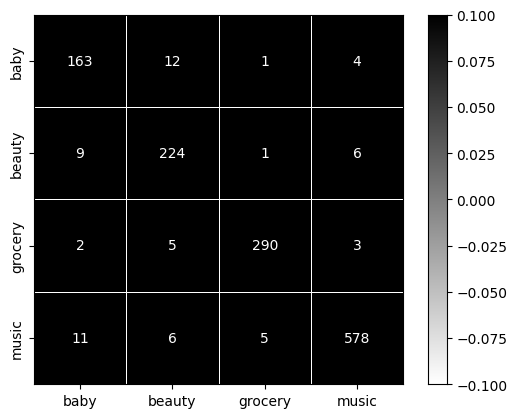

In [26]:
labels = ['baby','beauty','grocery','music']
sns.heatmap(cm, fmt='d', annot=True, square=True,
            cmap='gray_r', vmin=0, vmax=0,  # set all to white
            linewidths=0.5, linecolor='w',  # draw black grid lines
            xticklabels=labels,yticklabels=labels)                     # disable colorbar

# re-enable outer spines
sns.despine(left=False, right=False, top=False, bottom=False)

In [27]:
acc_score = accuracy_score(test['category'],test["predict"])
print("Test Accuracy Score",acc_score)

Test Accuracy Score 0.9507575757575758


#conclusion - IVF Index results are bit not accurate like flat index but this is slightly faster compared to flat index